In [13]:
from geopy.distance import geodesic
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import folium
from folium import plugins
from folium.plugins import MarkerCluster

In [14]:

#----- procesamiento de datos/ encontrando las distancias entre todas las locations -----
# https://geopy.readthedocs.io/en/stable/#module-geopy.distance 

clientes = pd.read_csv('Proyecto_Caso_Base/clients.csv')
depositos = pd.read_csv('Proyecto_Caso_Base/depots.csv')
vehiculos = pd.read_csv('Proyecto_Caso_Base/vehicles.csv')
for i in range(len(depositos)):
    data= {'LocationID': depositos['LocationID'][i],
            'Longitude': depositos['Longitude'][i],
            'Latitude': depositos['Latitude'][i],}
    data_f = pd.DataFrame([data])
    data_f.to_csv('Proyecto_Caso_Base/locations.csv', index=False)

for i in range(len(clientes)):
    data= {'LocationID': clientes['LocationID'][i],
            'Longitude': clientes['Longitude'][i],
            'Latitude': clientes['Latitude'][i],}
    data_f = pd.DataFrame([data])
    # modo a es de append pa ir añadiendo y como ya tiene encabezados header se pone en False
    data_f.to_csv('Proyecto_Caso_Base/locations.csv', mode='a', header=False, index=False)

locations_csv = pd.read_csv('Proyecto_Caso_Base/locations.csv')

distancias = []
for i in range(len(locations_csv)):
    latitud = locations_csv['Latitude'][i]
    longitud = locations_csv['Longitude'][i]
    coord = (latitud, longitud)
    locs_i=[]
    j=0
    #cuando hagamos los otros casos hay que cambiar ese 25
    while j<25:
        latitud2 = locations_csv['Latitude'][j]
        longitud2 = locations_csv['Longitude'][j]
        coord2 = (latitud2, longitud2)

        locs_i.append(geodesic(coord, coord2).kilometers)
    
        j+=1
    # df_locs_i = pd.DataFrame([locs_i])
    # df_locs_i.to_csv('Proyecto_Caso_Base/distancias.csv', mode='a', header=False, index=False)
    distancias.append(locs_i)


# Problema: CVRP con Capacidad y Autonomía en Entrega desde un Puerto

## 1. Formulación del Modelo
Dadas algunas correciones del enunciado y de nuestro modelo original, finalmente se creo este modelo matemático final. Los cambios principales subyacen en el manejo del parámetro de $distancia_{ij}$, y en el uso de las demanadas de cada cliente/municipio. A continuación se explicará cómo fue el modelo que implementamos en este primer caso.
### 1.1. Conjuntos

* $L = \{1, 2, ..., n\} $: Conjunto de localidades, donde \$1\$ representa el puerto.
* $D = \{2, ..., n\}$ : Conjunto de destinos/clientes.
* $V = \{1, ..., m\}$ : Conjunto de vehículos disponibles.

### 1.2. Índices

* $i, j \in L$ : Localidades origen y destino.
* $k \in V$ : Vehículo.

### 1.3. Parámetros

* $distancias_{ij}$: Distancia entre localidad $i$ y $j$.
* $D\_demanda\_i$: Demanda del cliente $i \in D$.
* $V\_capacidad\_k$: Capacidad máxima del vehículo $k$.
* $V\_autonomia\_k$: Autonomía máxima del vehículo $k$.
* $n$: Número total de localidades (incluye el puerto).

### 1.4. Variables de decisión

* $x_{ijk} \in {0,1}$: 1 si el vehículo $k$ viaja de $i$ a $j$, 0 en otro caso.
* $u_{ik} \in \mathbb{Z}$: Orden de visita de $i$ por el vehículo $k$ (usado para eliminar subciclos).

---

## 2. Función Objetivo

Minimizar la distancia total recorrida por todos los vehículos:

$$
\min \sum_{k \in V} \sum_{i \in L} \sum_{j \in L, j \ne i} distancias_{ij} \cdot x_{ijk}
$$

---

## 3. Restricciones

### (0) Prohibir viajes del puerto a sí mismo:

$$
x_{11k} = 0 \quad \forall k \in V
$$

### (1) Cada cliente debe ser visitado exactamente una vez:

$$
\sum_{k \in V} \sum_{\substack{i \in L \\ i \ne j}} x_{ijk} = 1 \quad \forall j \in D
$$

### (2) Cada vehículo debe salir una sola vez del puerto:

$$
\sum_{j \in L, j \ne 1} x_{1jk} = 1 \quad \forall k \in V
$$

### (3) Cada vehículo debe regresar una vez al puerto:

$$
\sum_{i \in L, i \ne 1} x_{i1k} = 1 \quad \forall k \in V
$$

### (4) Conservación de flujo en los nodos:

$$
\sum_{\substack{i \in L \\ i \ne h}} x_{ihk} = \sum_{\substack{j \in L \\ j \ne h}} x_{hjk} \quad \forall h \in D, \forall k \in V
$$

### (5) Eliminación de subciclos (MTZ):

$$
u_{ik} - u_{jk} + n \cdot x_{ijk} \leq n - 1 \quad \forall i \ne j \in D, \forall k \in V
$$

### (6) Capacidad de cada vehículo:

$$
\sum_{i \in D} D\_demanda_i \cdot \sum_{\substack{j \in L \\ j \ne i}} x_{ijk} \leq V\_capacidad_k \quad \forall k \in V
$$

### (7) Autonomía de cada vehículo:

$$
\sum_{\substack{i,j \in L \\ i \ne j}} distancias_{ij} \cdot x_{ijk} \leq V\_autonomia_k \quad \forall k \in V
$$

---



In [15]:

#----- modelo para resolver el caso base -----
# Implementar un modelo básico tipo CVRP con un origen nacional (puerto) y destinos (municipios).
# Incluir restricciones de capacidad y autonomía de los vehículos.
# Validar factibilidad de la solución considerando solamente distancia y demanda.

Model = ConcreteModel()

numPuertos = 1
numPuntosDestino = 24
numLocalidades = len(distancias)
numVehiculos = 8

# Conjuntos
P= RangeSet(1, numPuertos) 
D = RangeSet(2, numLocalidades)   
V = RangeSet(1, numVehiculos)
L= RangeSet(1, numLocalidades)
nodos = [_ for _ in range(numLocalidades)]


# Parámetros
D_demanda = {}
for i in range(2, numPuntosDestino+2):
    D_demanda[i] = clientes['Demand'][i-2]

V_capacidad = {}
for i in range(1, numVehiculos+1):
    V_capacidad[i] = vehiculos['Capacity'][i-1]
    
V_autonomia = {}
for i in range(1, numVehiculos+1):
    V_autonomia[i] = vehiculos['Range'][i-1]


# Variables de decisión
Model.x = Var(L,L,V, domain=Binary) # x[i,j,k] = 1 si el vehiculo k viaja de i a j
Model.u = Var(D, V, bounds=(1, numLocalidades - 1), domain=Integers) # u[i,k] = número de localidades visitadas por el vehículo k al visitar la localidad i 


# Función objetivo: minimizar la distancia total recorrida
Model.obj = Objective(
    expr=sum(distancias[i-1][j-1]*Model.x[i,j,k] 
             for i in L for j in L for k in V if i != j),
    sense=minimize
)

# Restricción 0: el vehículo no puede salir del puerto/deposito para visitar el puerto/deposito
# (esto es para evitar que el vehículo salga y vuelva al puerto/deposito sin visitar ningún cliente)
Model.res0 = ConstraintList()
for k in V:
    Model.res0.add(Model.x[1, 1, k] == 0)


# Restricción 1: cada cliente debe ser visitado exactamente una vez
Model.res1 = ConstraintList()
for j in D:
    Model.res1.add(
        sum(Model.x[i,j,k] for i in L if i != j for k in V) == 1
    )

# Restricción 2: desde el depósito/puerto sale un nodo por vehículo
Model.res2 = ConstraintList()
for k in V:
    Model.res2.add(
        sum(Model.x[1,j,k] for j in L if j != 1) == 1
    )

# Restricción 3: al depósito/puerto llega un nodo por vehículo
Model.res3 = ConstraintList()
for k in V:
    Model.res3.add(
        sum(Model.x[i,1,k] for i in L if i != 1) == 1
    )

# Restricción 4: si un vehículo entra a un nodo, también debe salir de él. Conservación de flujo
Model.res4 = ConstraintList()
for k in V:
    for h in D:
        Model.res4.add(
            sum(Model.x[i,h,k] for i in L if i != h) == sum(Model.x[h,j,k] for j in L if j != h)
        )

# Restricción 5: eliminación de subciclos (MTZ)
Model.res5 = ConstraintList()
for k in V:
    for i in D:
        for j in D:
            
            if i != j:
                Model.res5.add(
                    Model.u[i,k] - Model.u[j,k] + numLocalidades * Model.x[i,j,k] <= numLocalidades - 1
                )

# Restricción 6 : Capacidad de cada vehículo
Model.res6 = ConstraintList()
for k in V:
    Model.res6.add(
        sum(D_demanda[i] * sum(Model.x[i,j,k] for j in L if i != j) for i in D) <= V_capacidad[k]
    )

# Restricción 7: Autonomía de cada vehículo
Model.res7 = ConstraintList()
for k in V:
    Model.res7.add(
        sum(distancias[i-1][j-1] * Model.x[i,j,k] for i in L for j in L if i != j) <= V_autonomia[k]
    )

solver = SolverFactory('glpk')
solver.options['tmlim'] = 300 # tiempo límite de 5 minutos
results = solver.solve(Model, tee=True)


velocidad = 50  # km/h - estimación de velocidad promedio
tarifa_flete = 5000
costo_mantenimiento = 700
costo_km = tarifa_flete + costo_mantenimiento  # 5700
for k in V:
    ruta = [1]  # siempre inicia en PTO
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break

    ruta_nombres = ["PTO"] + [f"MUN{str(nodo).zfill(2)}" for nodo in ruta[1:-1]] + ["PTO"]

    demandas = [D_demanda[n] for n in ruta if n in D_demanda]
    total_demanda = sum(demandas)
    total_distancia = sum(distancias[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1))
    tiempo = round(total_distancia / velocidad, 2)
    costo = round(total_distancia * costo_km)

    print(f"{k} CAM{str(k).zfill(3)} ,{V_capacidad[k]} ,{V_autonomia[k]} , {' - '.join(ruta_nombres)}")
    print(f",→ ,{len(demandas)} ,{' - '.join(str(d) for d in demandas)} ,{total_demanda} ,{V_autonomia[k]} ,{round(total_distancia,1)} ,{tiempo} ,{costo}")

# Calcular la distancia total recorrida por todos los vehículos
distancia_total = 0
for k in V:
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break
    distancia_total += sum(distancias[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1))

print(f"Distancia total recorrida por todos los vehículos: {round(distancia_total, 2)} km")




GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 300 --write C:\Users\GABRIE~1\AppData\Local\Temp\tmpa1e93drx.glpk.raw
 --wglp C:\Users\GABRIE~1\AppData\Local\Temp\tmpur2n2gst.glpk.glp --cpxlp
 C:\Users\GABRIE~1\AppData\Local\Temp\tmp3vx6avae.pyomo.lp
Reading problem data from 'C:\Users\GABRIE~1\AppData\Local\Temp\tmp3vx6avae.pyomo.lp'...
C:\Users\GABRIE~1\AppData\Local\Temp\tmp3vx6avae.pyomo.lp:60894: warning: lower bound of variable 'x1' redefined
C:\Users\GABRIE~1\AppData\Local\Temp\tmp3vx6avae.pyomo.lp:60894: warning: upper bound of variable 'x1' redefined
4673 rows, 5001 columns, 36873 non-zeros
5000 integer variables, 4808 of which are binary
65702 lines were read
Writing problem data to 'C:\Users\GABRIE~1\AppData\Local\Temp\tmpur2n2gst.glpk.glp'...
56016 lines were written
GLPK Integer Optimizer 5.0
4673 rows, 5001 columns, 36873 non-zeros
5000 integer variables, 4808 of which are binary
Preprocessing...
4416 constraint coefficient(s) were redu

# Discusiones de respuestas
## Resultados Solver
### Justificación de solver
GLPK (GNU Linear Programming Kit) es un solver libre y de código abierto diseñado para resolver problemas de programación lineal (LP) y programación entera mixta (MIP). En el contexto del Problema de Ruteo de Vehículos con Capacidad y Autonomía (CVRP), se trata de un problema clásico de optimización combinatoria que involucra variables binarias y restricciones lineales, lo que lo hace compatible con GLPK.Aunque el solver no alcanzó la solución óptima debido al límite de tiempo, logró encontrar una solución factible con un gap aceptable del 17.2%, lo que indica una solución cercana al óptimo. Adicionalmente, GLPK manejó correctamente la estructura del modelo (más de 300,000 nodos de búsqueda), lo que demuestra su estabilidad en instancias medianas del problema.


### Resumen del Proceso de Optimización (GLPK)

| Métrica                          | Valor                             |
|----------------------------------|------------------------------------|
| Escalado inicial (A)             | min = 0.3446, max = 25.00, ratio ≈ 72.55 |
| Escalado con GM                  | min = 0.3063, max = 3.265, ratio ≈ 10.66 |
| Escalado EQ                      | min = 0.09381, max = 1.00, ratio ≈ 10.66 |
| Escalado 2N                      | min = 0.08615, max = 1.50, ratio ≈ 17.41 |
| Fase LP: valor objetivo inicial  | 219.355                            |
| Fase LP: valor óptimo relajación | 150.904                            |
| Tiempo total usado (límite)      | 300 segundos                       |
| Memoria usada                    | 269.6 MB                           |
| GAP final                        | 17.2%                              |
| Soluciones enteras encontradas   | múltiples                          |
| Estado final                     | Límite de tiempo alcanzado (factible) |

## Rutas por Vehículo y Costos

| Vehículo | Capacidad | Autonomía | Ruta                                     | # Clientes | Demanda Total | Distancia (km) | Tiempo (h) | Costo ($) |
|----------|-----------|-----------|------------------------------------------|------------|----------------|----------------|------------|-----------|
| CAM001   | 130       | 170       | PTO - MUN15 - PTO                        | 1          | 15             | 8.0            | 0.16       | 45,636    |
| CAM002   | 140       | 200       | PTO - MUN06 - MUN09 - ... - MUN19 - PTO | 8          | 133            | 54.6           | 1.09       | 310,980   |
| CAM003   | 120       | 180       | PTO - MUN10 - ... - MUN07 - PTO         | 7          | 118            | 43.8           | 0.88       | 249,732   |
| CAM004   | 100       | 90        | PTO - MUN24 - PTO                        | 1          | 15             | 8.6            | 0.17       | 49,173    |
| CAM005   | 70        | 100       | PTO - MUN13 - PTO                        | 1          | 12             | 11.9           | 0.24       | 67,788    |
| CAM006   | 55        | 170       | PTO - MUN04 - PTO                        | 1          | 12             | 12.7           | 0.25       | 72,622    |
| CAM007   | 110       | 150       | PTO - MUN03 - ... - MUN22 - PTO         | 4          | 57             | 37.1           | 0.74       | 211,329   |
| CAM008   | 114       | 140       | PTO - MUN21 - PTO                        | 1          | 15             | 7.1            | 0.14       | 40,264    |

### Distancia Total Recorrida: **183.78 km**


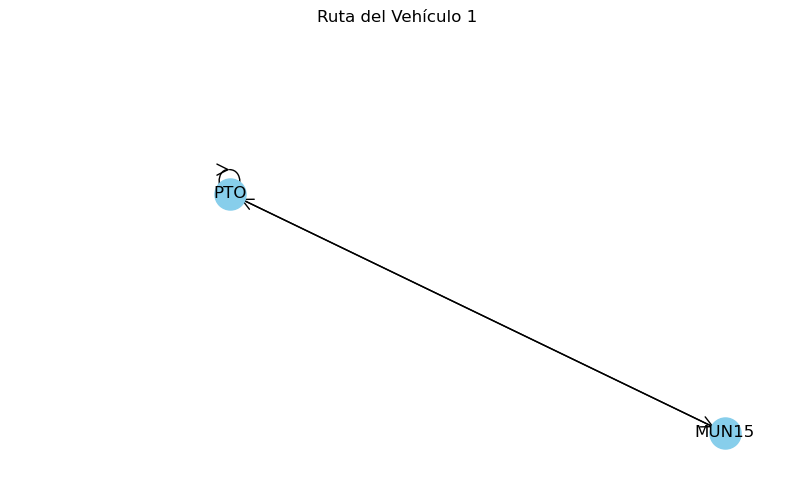

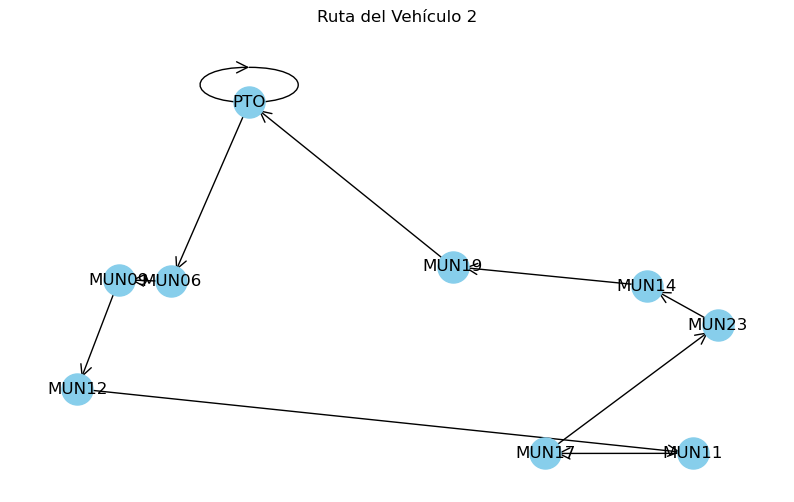

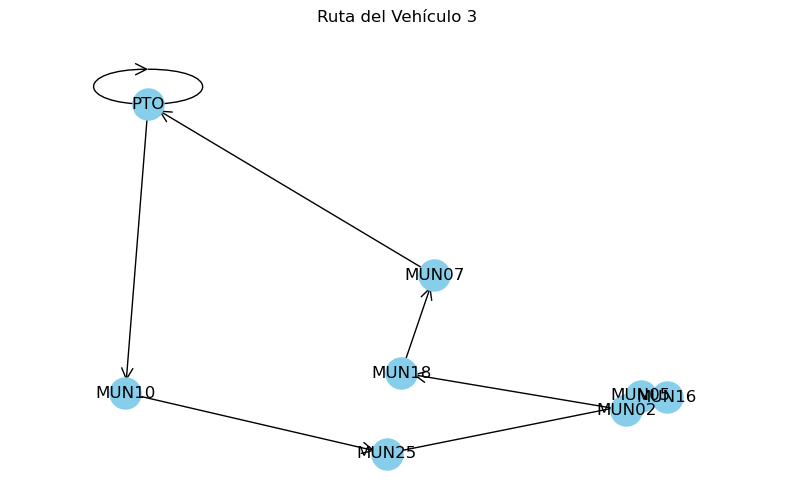

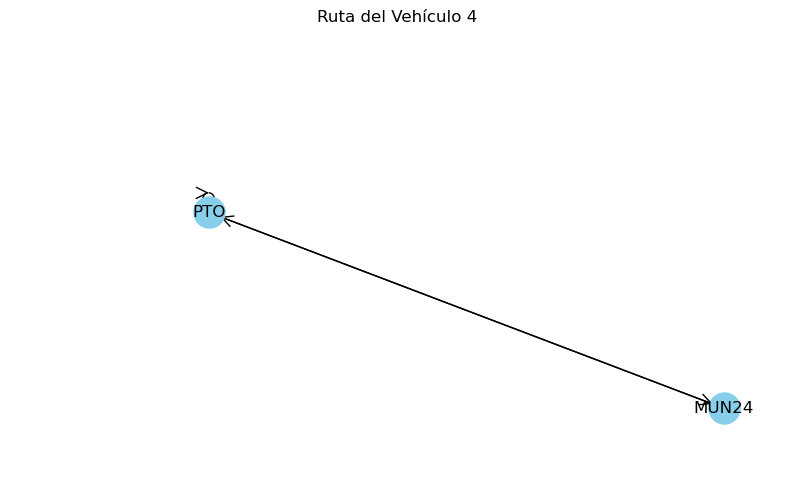

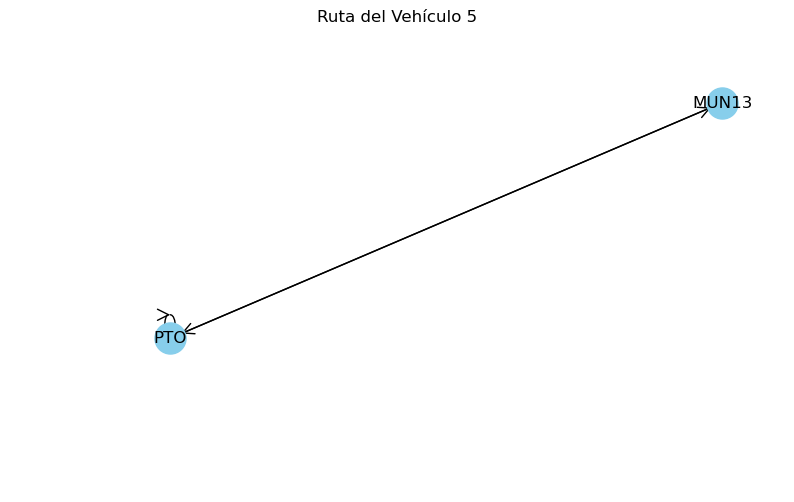

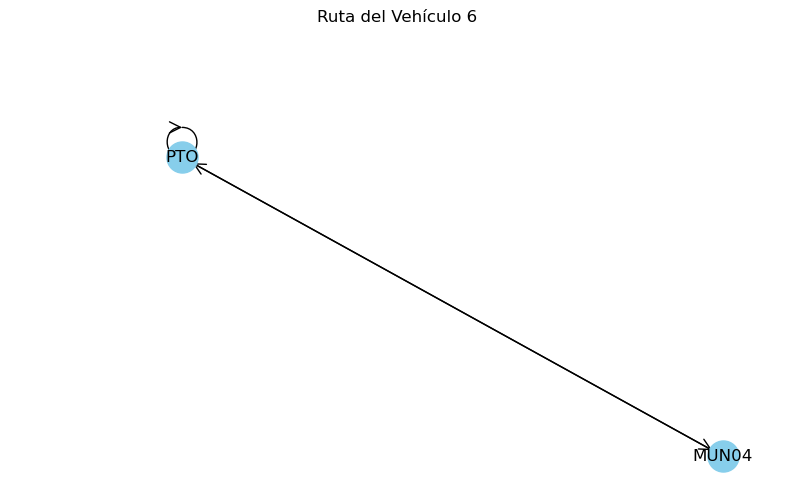

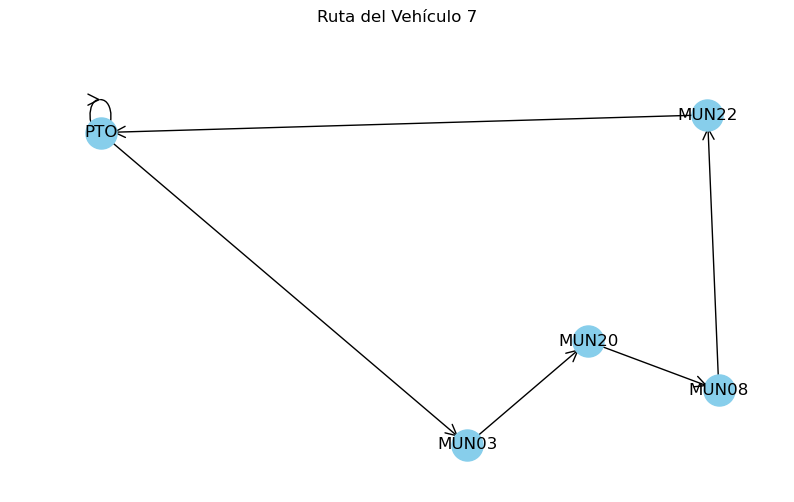

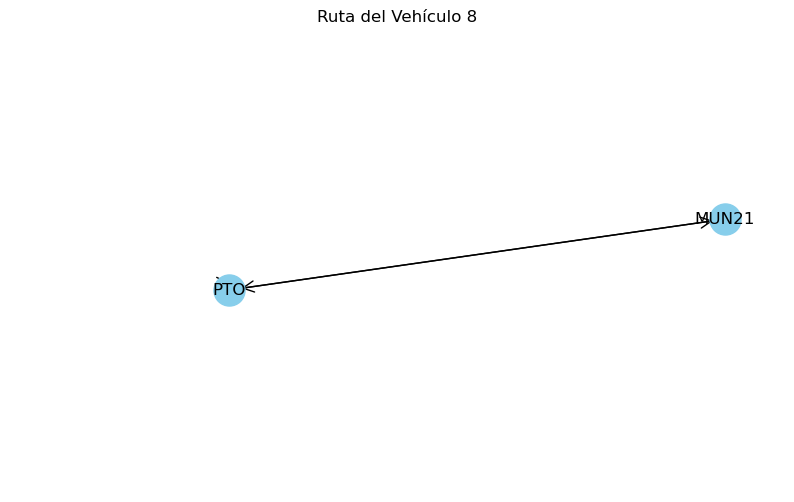

In [19]:
# Coordenadas de cada nodo
coords = {i+1: (locations_csv['Longitude'][i], locations_csv['Latitude'][i]) for i in range(len(locations_csv))}

for k in V:
    G = nx.DiGraph()
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break

    if len(ruta) > 1:
        ruta.append(1)  # cerrar ciclo

        G.add_nodes_from(ruta)
        for i in range(len(ruta)-1):
            G.add_edge(ruta[i], ruta[i+1])

        plt.figure(figsize=(10,6))
        pos = {n: coords[n] for n in ruta}
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
        nx.draw_networkx_labels(G, pos, labels={n: f"{'PTO' if n==1 else f'MUN{n:02d}'}" for n in ruta})
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
        plt.title(f"Ruta del Vehículo {k}")
        plt.axis('off')
        plt.show()


C:\Users\Gabriela Escobar\AppData\Local\Temp\ipykernel_36964\5199535.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab10', len(V))  # Usa una paleta de 10 colores


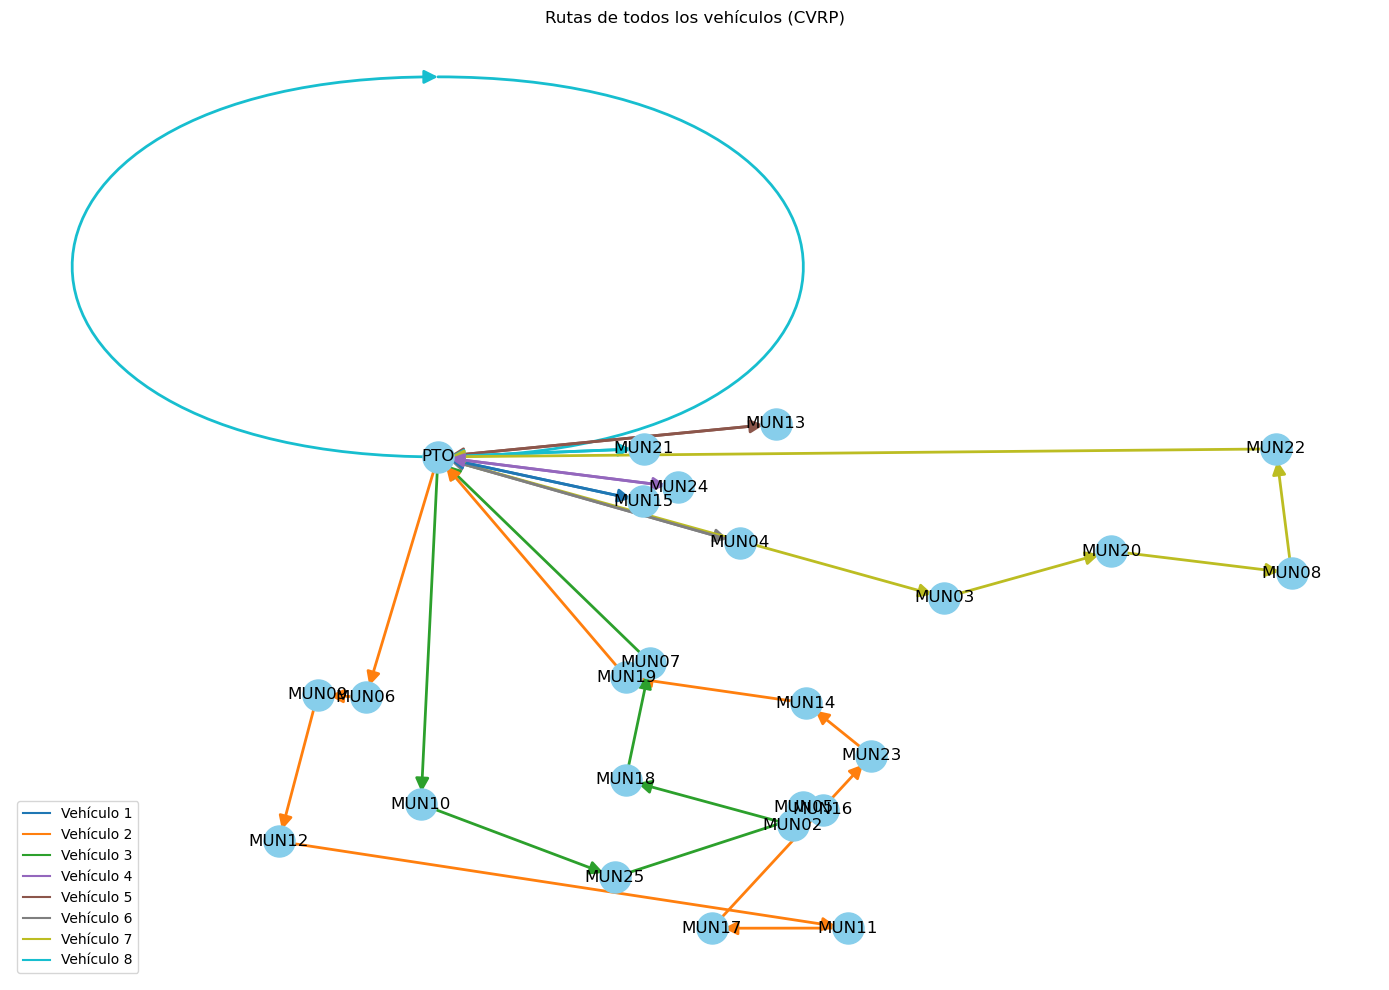

In [20]:
# Crear coordenadas a partir del CSV
coords = {i+1: (locations_csv['Longitude'][i], locations_csv['Latitude'][i]) for i in range(len(locations_csv))}

# Crear grafo general
G = nx.DiGraph()

# Agregar todos los nodos
G.add_nodes_from(coords.keys())

# Colores únicos para cada vehículo
color_map = cm.get_cmap('tab10', len(V))  # Usa una paleta de 10 colores

# Construir rutas por vehículo y agregarlas al grafo
for idx, k in enumerate(V):
    color = mcolors.to_hex(color_map(idx))
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break

    if len(ruta) > 1:
        ruta.append(1)  # cerrar ciclo
        for i in range(len(ruta)-1):
            G.add_edge(ruta[i], ruta[i+1], color=color, vehicle=k)

# Obtener posiciones de los nodos (longitud, latitud)
pos = {n: coords[n] for n in G.nodes}

# Dibujar nodos
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels={n: f"{'PTO' if n==1 else f'MUN{n:02d}'}" for n in G.nodes})

# Dibujar aristas coloreadas por vehículo
edges = G.edges(data=True)
for edge in edges:
    i, j, attr = edge
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(i, j)],
        edge_color=attr['color'],
        width=2,
        arrows=True,
        arrowsize=20
    )

# Agregar leyenda de vehículos
for idx, k in enumerate(V):
    plt.plot([], [], color=mcolors.to_hex(color_map(idx)), label=f'Vehículo {k}')
plt.legend(loc='lower left')

plt.title("Rutas de todos los vehículos (CVRP)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [22]:
# Cargar coordenadas
coordenadas = locations_csv[['Latitude', 'Longitude']].values.tolist()

# Crear mapa centrado en el depósito
lat_centro = coordenadas[0][0]
lon_centro = coordenadas[0][1]
mapa = folium.Map(location=[lat_centro, lon_centro], zoom_start=8)

# Colores para diferenciar vehículos
colores = [
    'blue', 'orange', 'green', 'purple', 'brown', 'olive', 'gray', 'cyan'
]

# Costos
velocidad = 50
tarifa_flete = 5000
costo_mantenimiento = 700
costo_km = tarifa_flete + costo_mantenimiento  # 5700

# Añadir puntos al mapa
for i, coord in enumerate(coordenadas):
    nombre = "PTO" if i == 0 else f"MUN{str(i).zfill(2)}"
    folium.CircleMarker(location=coord, radius=4, color="black", fill=True, popup=nombre).add_to(mapa)

# Añadir rutas
for k in V:
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break
    if len(ruta) <= 1:
        continue  # vehículo no utilizado

    # Coordenadas y etiquetas
    puntos = [coordenadas[i-1] for i in ruta]
    distancia = sum(distancias[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1))
    costo = round(distancia * costo_km)

    folium.PolyLine(
        puntos,
        color=colores[k-1],
        weight=4,
        opacity=0.8,
        tooltip=f'🚚 Vehículo {k} - Distancia: {round(distancia,1)} km - Costo: ${costo}'
    ).add_to(mapa)

# Guardar
mapa.save('Proyecto_Caso_Base/ruta_vehiculos_interactiva.html')
print("✅ Mapa interactivo guardado como 'ruta_vehiculos_interactiva.html'")

✅ Mapa interactivo guardado como 'ruta_vehiculos_interactiva.html'


## 🗺️ Cómo visualizar el mapa interactivo de rutas con Folium

Este procedimiento permite generar y visualizar un mapa interactivo con las rutas de vehículos calculadas por el modelo CVRP, usando la librería `folium`.

---

### 🔧 Paso 1: Asegúrate de haber ejecutado el código de generación

Verifica que tu código de Python haya generado el archivo `ruta_vehiculos_interactiva.html` en la carpeta `Proyecto_Caso_Base`. El mensaje debe decir:

---

### 🗂️ Paso 2: Ubica el archivo generado

En tu explorador de archivos, navega a:

Proyecto_Caso_Base/mapaInteractivoCasoBasico 

![MapaInteractivo](Proyecto_Caso_Base/mapaInteractivoCasoBasico.png)

Haz doble clic en el archivo `ruta_vehiculos_interactiva.html`. Esto abrirá el archivo en tu navegador predeterminado (Chrome, Firefox, Edge, etc.). Alternativamente:

- Puedes arrastrar el archivo hasta una ventana abierta de tu navegador.
- O hacer clic derecho > "Abrir con" > elige tu navegador.

---


